<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_8_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer shows why:

---


## Visualizing deep learning for fun and profit

### Dr. Eyal Gruss

slides: https://bit.ly/vis-dl


This notebook is derived from https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb

In [0]:
# install keras-vis master version

!pip install -U git+git://github.com/raghakot/keras-vis.git

  Cloning git://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-9bq94f7j
  Running command git clone -q git://github.com/raghakot/keras-vis.git /tmp/pip-req-build-9bq94f7j
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=bae252d82edb971d10ee5ad77b2cf3694aeaab324cacb65c53668b743bd35300
  Stored in directory: /tmp/pip-ephem-wheel-cache-dcdolgjd/wheels/ff/01/8e/3a66d951f9b53f9894a010107b05253fb9a6c6f2555a5aaeca
Successfully built keras-vis
  Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


Using TensorFlow backend.


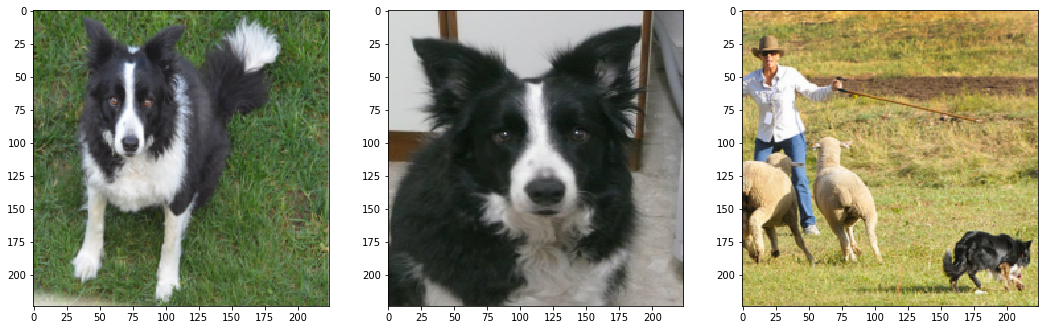

In [0]:
# download and display some images

%tensorflow_version 1.x

from vis.utils import utils
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (18, 24)

urls = ['https://i.imgur.com/raG3QsN.jpg', 'https://i.imgur.com/DGnn1nt.jpg', 'https://i.imgur.com/tQMznEK.png']

imgs = [utils.load_img(url, target_size=(224, 224))[..., :3] for url in urls]

f, ax = plt.subplots(1, len(imgs))
for i in range(len(imgs)):
  ax[i].imshow(imgs[i])


--2019-11-14 22:14:49--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2019-11-14 22:14:49 (2.74 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]













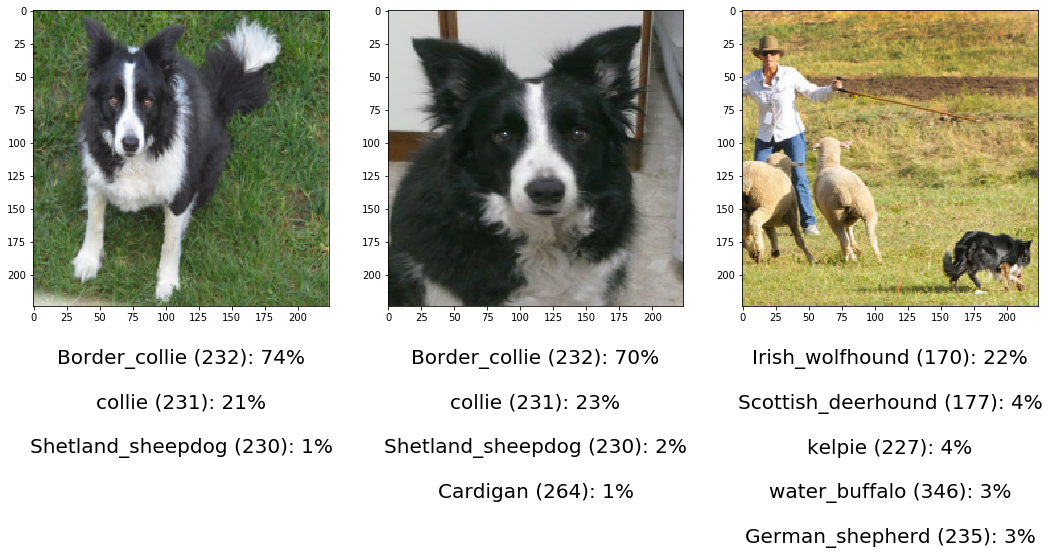

In [0]:
# download imagenet recognition model and predict on images

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import json
import numpy as np
plt.rcParams['axes.labelsize'] = 20

top = 5
min_prob = 0.01

!wget -N https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
with open('imagenet_class_index.json') as f:
    CLASS_INDEX = json.load(f)
label2index = {CLASS_INDEX[i][1]:int(i) for i in CLASS_INDEX}

model = VGG16(weights='imagenet')
preproc_imgs = [preprocess_input(img) for img in imgs]
probs = [model.predict(np.expand_dims(img, axis=0)) for img in preproc_imgs]
preds = [decode_predictions(prob, top=top)[0] for prob in probs]

f, ax = plt.subplots(1, len(imgs))
for i in range(len(imgs)):
  ax[i].imshow(imgs[i])
  ax[i].set_xlabel('\n'.join('\n%s (%d): %d%%'%(pred[1], label2index[pred[1]], pred[2]*100) for pred in preds[i] if pred[2]>min_prob))

In [0]:
from vis.visualization import visualize_saliency, visualize_cam
from keras import activations
import matplotlib.cm as cm
import cv2

# change final activation from softmax to linear
layer_index = -1
model.layers[layer_index].activation = activations.linear
model_linear = utils.apply_modifications(model)

def viz(filter_indices, method='sal', sal_backprop_modifier='guided', cam_backprop_modifier=None, sal_grad_modifier='absolute', cam_grad_modifier=None, layer_index=-1, penultimate_layer_idx=None, quantile=0.99, alpha=0.7, auto_alpha=True, linear=True):
  if linear:
    model1 = model_linear
  else:
    model1 = model

  f, ax = plt.subplots(2 if method=='cam' else 4, len(imgs))
  if method=='cam':
    f.set_figheight(12)
  for i in range(len(imgs)):
    grads = None
    grads_cam = 1
    if method in ('sal','both'):
      grads_sal = visualize_saliency(model1, layer_index, filter_indices, preproc_imgs[i], backprop_modifier=sal_backprop_modifier, grad_modifier=sal_grad_modifier)
      grads = grads_sal
    if method in ('cam','both'):
      grads_cam = visualize_cam(model1, layer_index, filter_indices, preproc_imgs[i], backprop_modifier=cam_backprop_modifier, grad_modifier=cam_grad_modifier, penultimate_layer_idx=None)
      if method =='cam':
        grads = grads_cam
    if grads is None:
      raise NotImplementedError

    ax[0,i].imshow(grads*grads_cam, cmap='jet')
    if method!='cam':
      if quantile:
        grads = np.clip(grads,0,np.quantile(grads, quantile))
      ax[1,i].imshow(grads*grads_cam, cmap='jet')

      grads = cv2.GaussianBlur(grads, (9,9), 0)
      ax[2,i].imshow(grads*grads_cam, cmap='jet')

    grads *= grads_cam
    if grads.max()>grads.min():
      grads = (grads-grads.min())/(grads.max()-grads.min())

    heatmap = cm.jet(grads)[...,:3]
    alpha_filter = alpha
    if auto_alpha:
      alpha_filter *= np.expand_dims(grads, axis=-1)
    gray = imgs[i].mean(axis=-1, keepdims=True)/255
    ax[1 if method=='cam' else 3 ,i].imshow(alpha_filter*heatmap+(1-alpha_filter)*gray)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


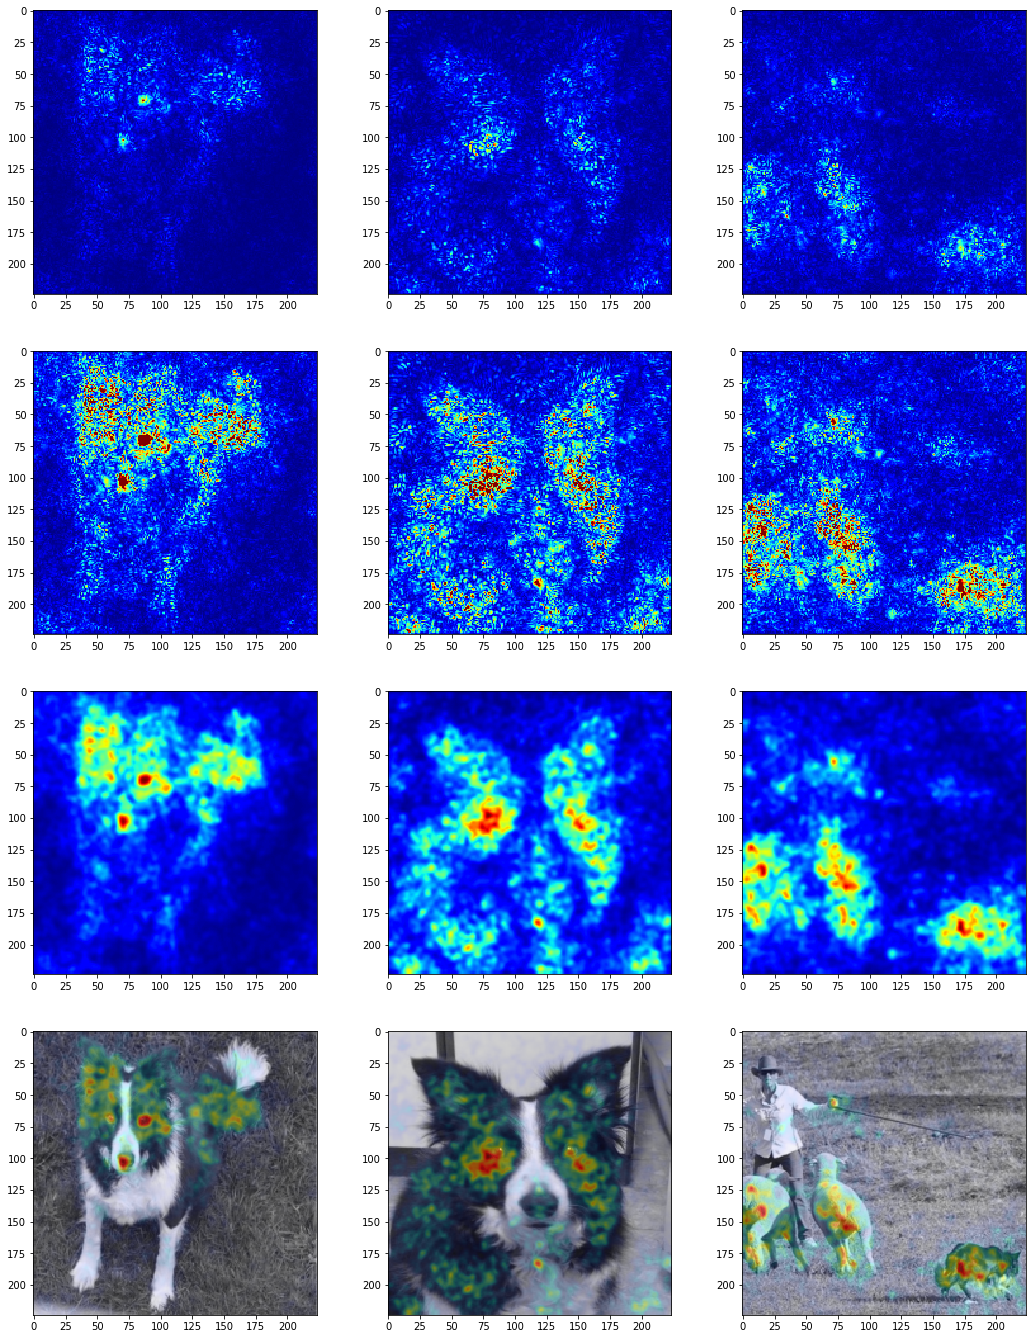

In [0]:
# simple gradients - not so good
viz(filter_indices=label2index['Border_collie'], sal_backprop_modifier=None)

#Guided Backprop (https://arxiv.org/abs/1412.6806)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


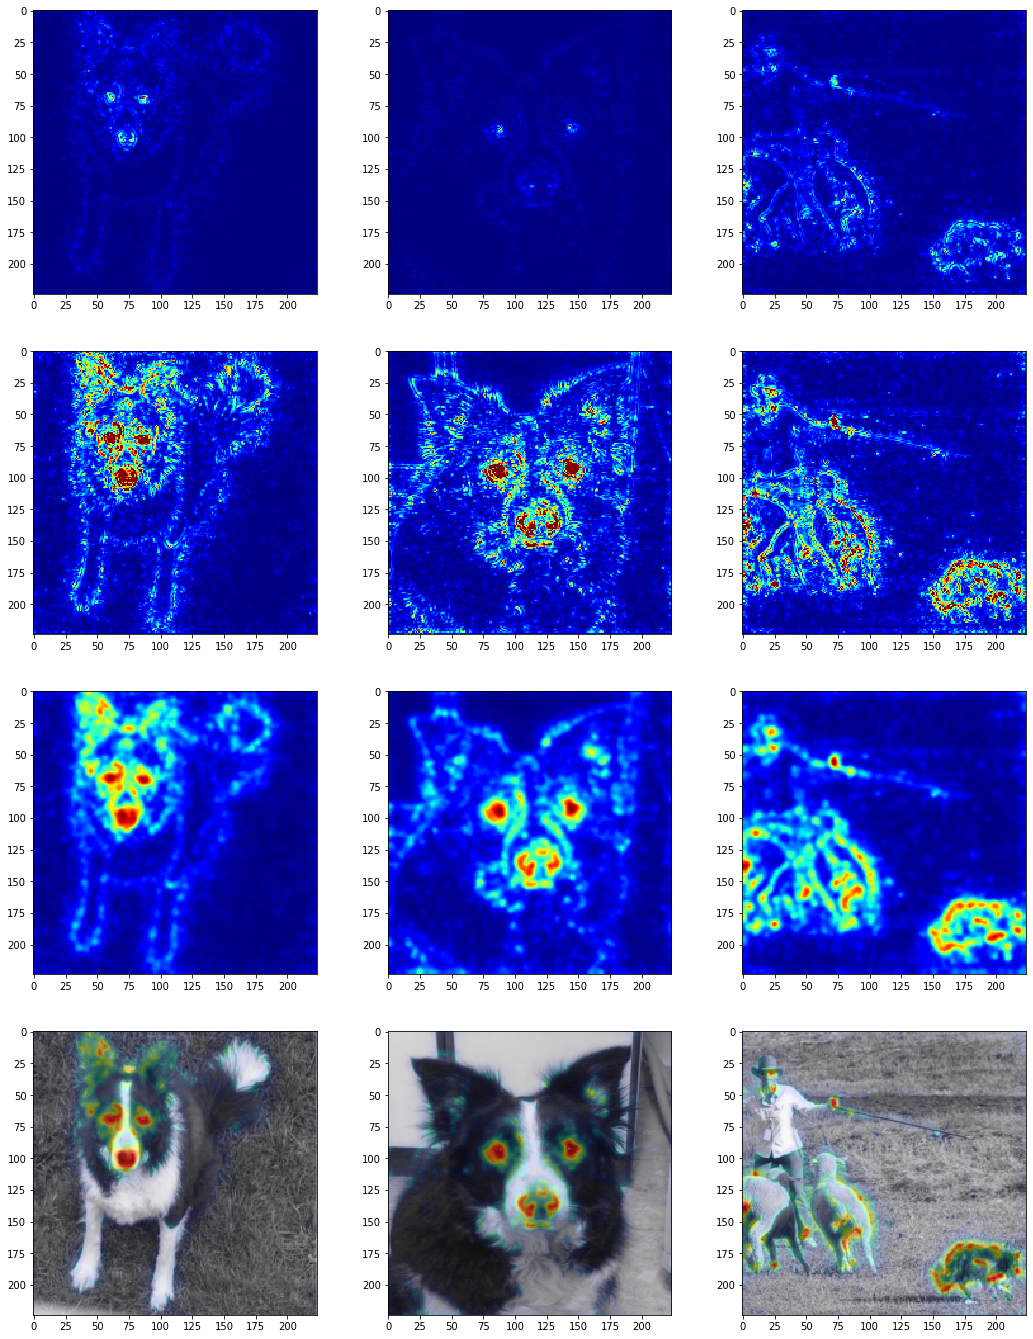

In [0]:
viz(filter_indices=label2index['Border_collie'])

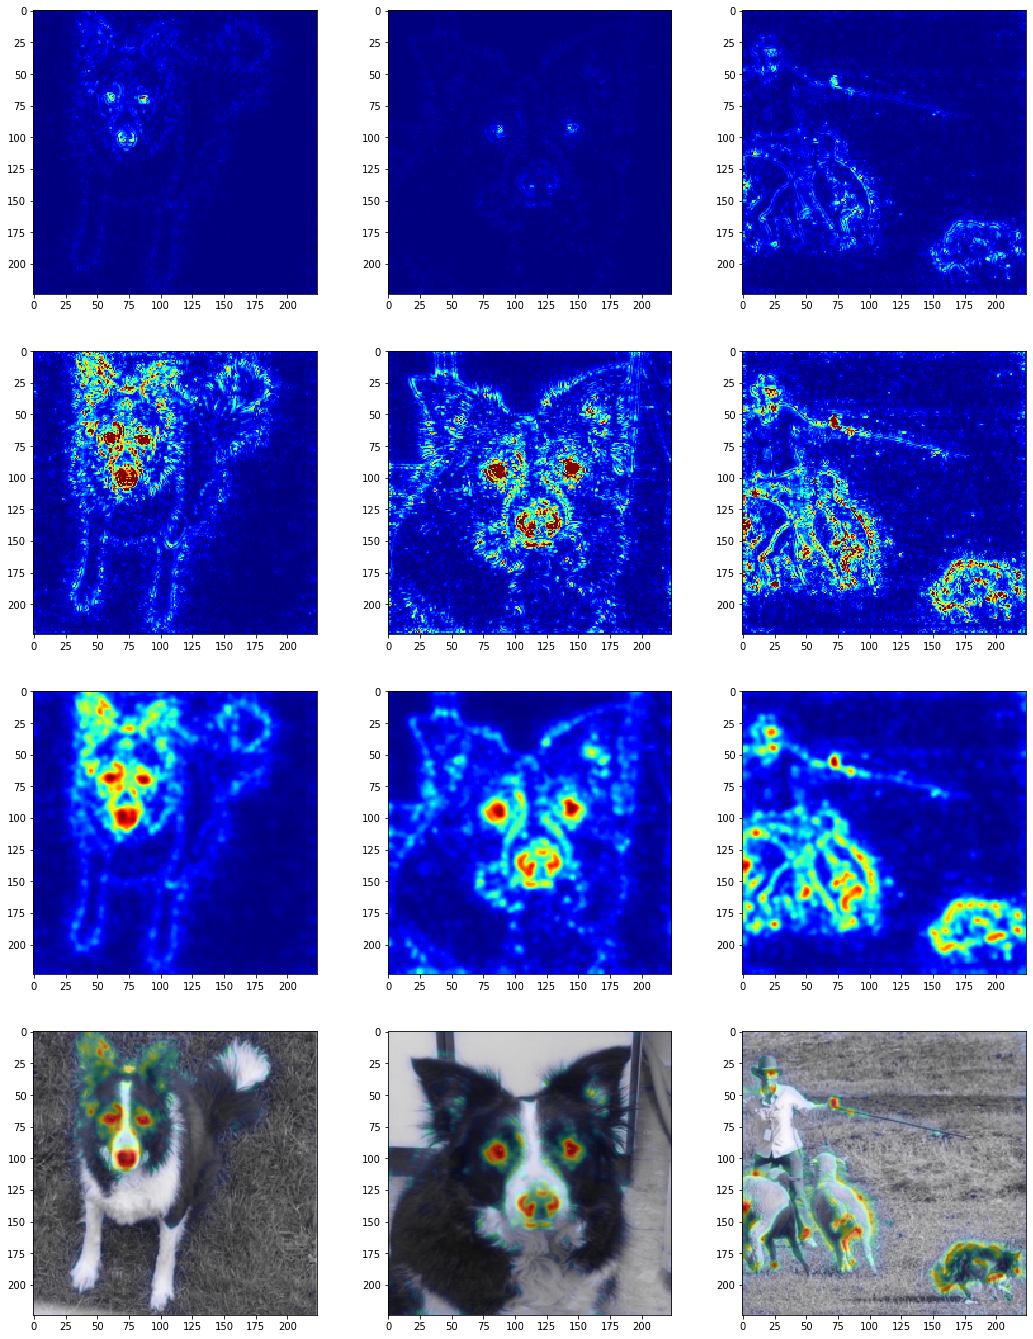

In [0]:
#Note backprop is not descriminative between different output labels:
viz(filter_indices=label2index['space_shuttle'])

#Grad-CAM (https://arxiv.org/abs/1610.02391)

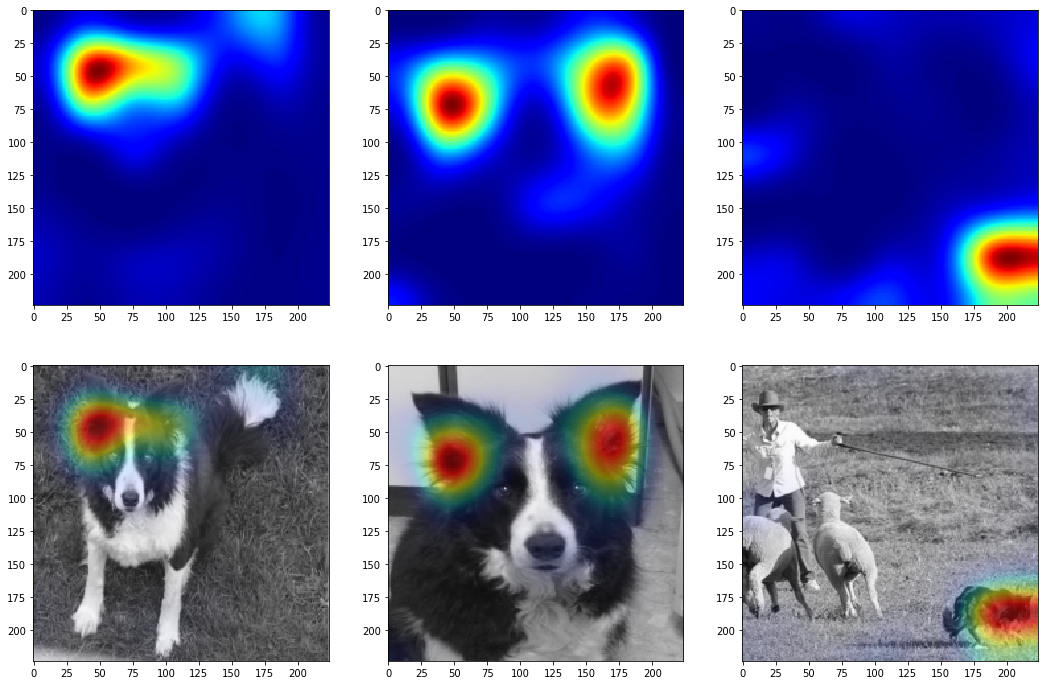

In [0]:
viz(filter_indices=label2index['Border_collie'], method='cam')

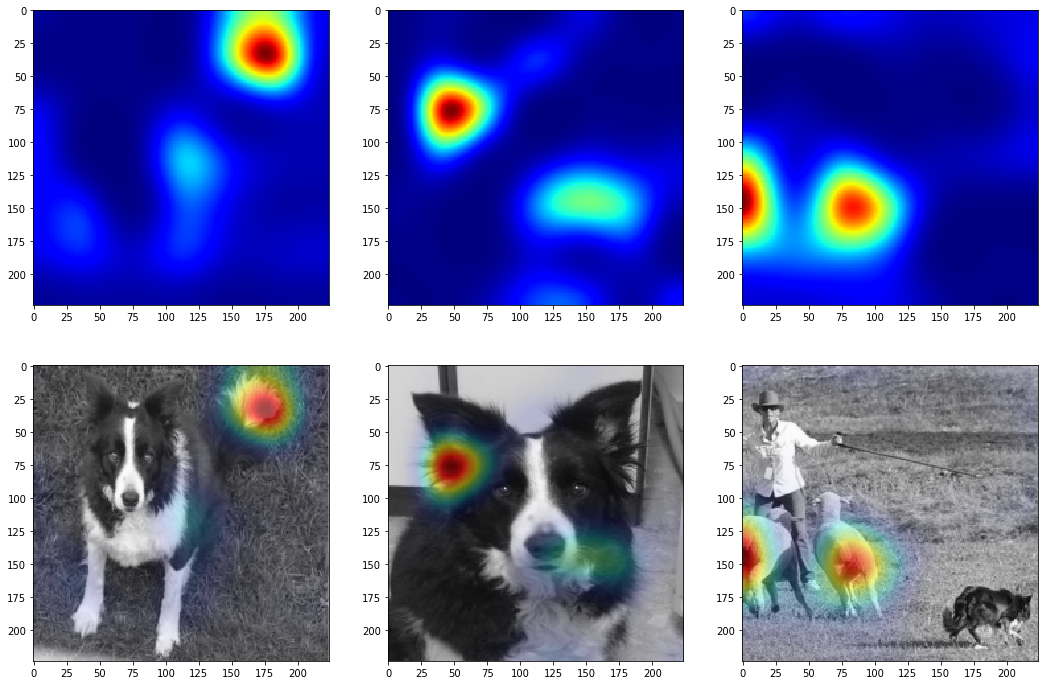

In [0]:
viz(filter_indices=label2index['ram'], method='cam')

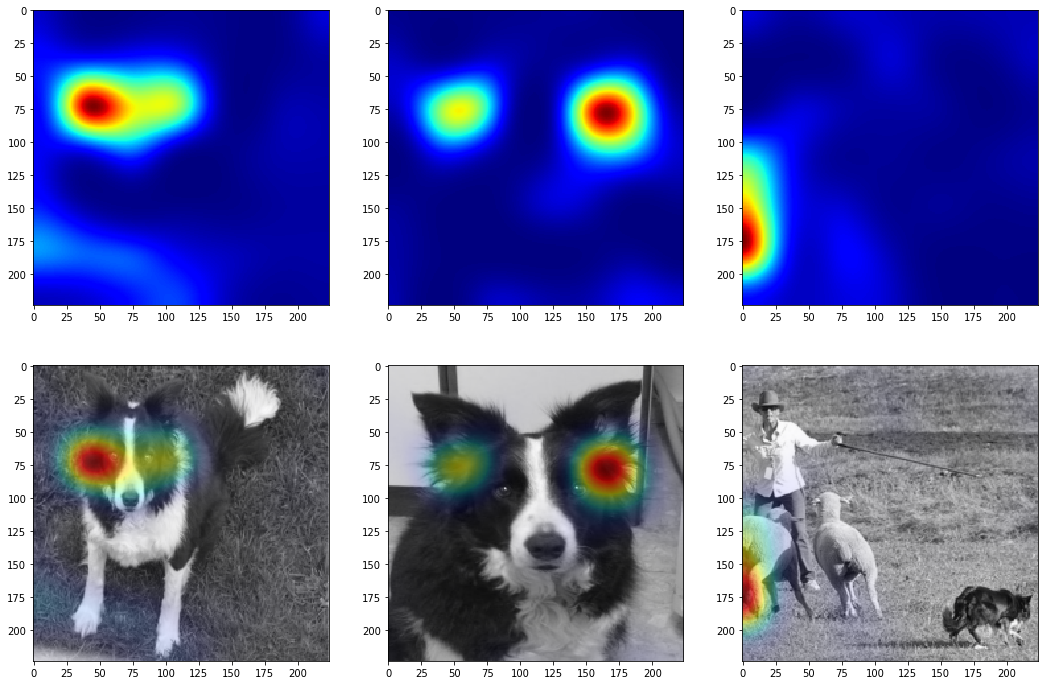

In [0]:
viz(filter_indices=label2index['Irish_wolfhound'], method='cam')

da real Irish wolfhound
![da real Irish wolfhound](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Irish_wolfhound_giaccomo.JPG/1024px-Irish_wolfhound_giaccomo.JPG)

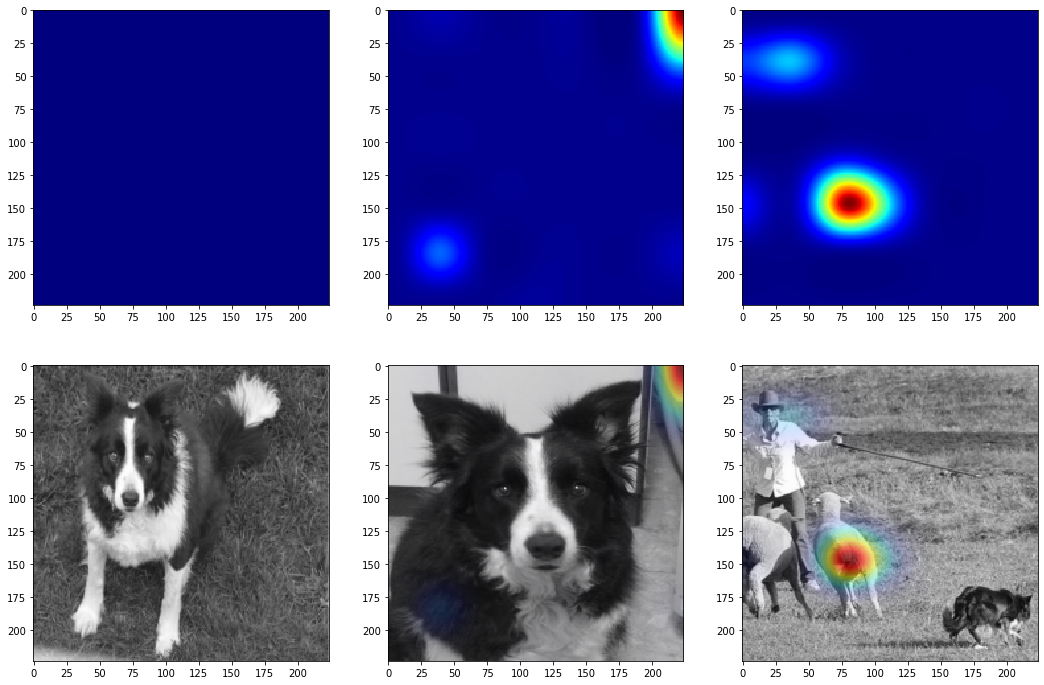

In [0]:
#negate
viz(filter_indices=label2index['Border_collie'], method='cam', cam_grad_modifier='negate')

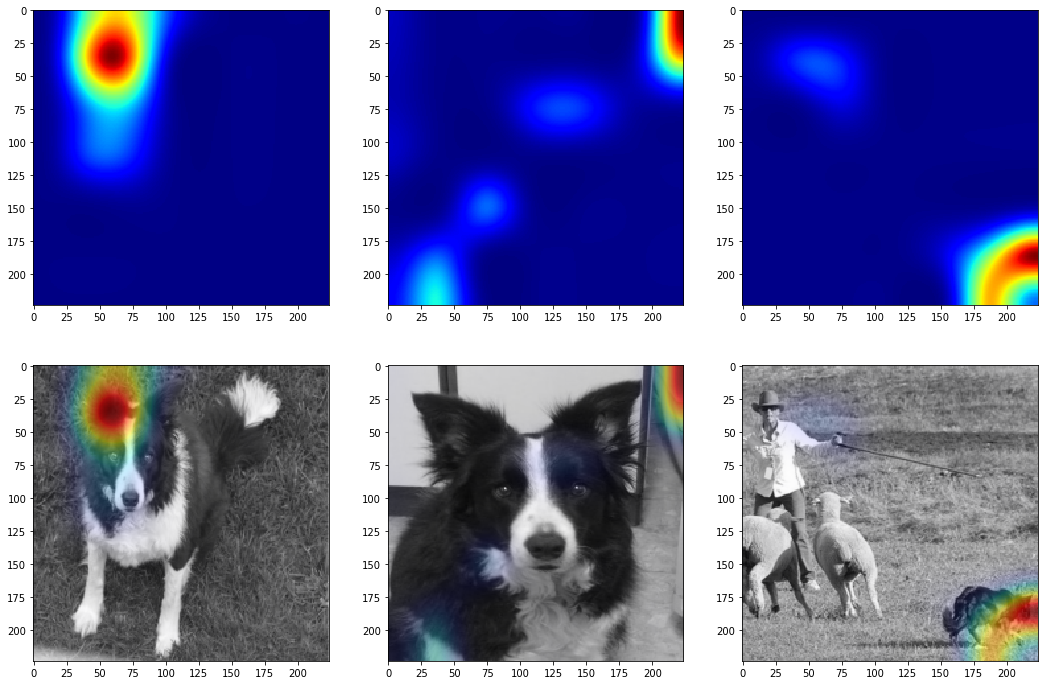

In [0]:
viz(filter_indices=label2index['ram'], method='cam', cam_grad_modifier='negate')

#Guided Grad-CAM = Guided Backprop * Grad-CAM (Grad-CAM paper)

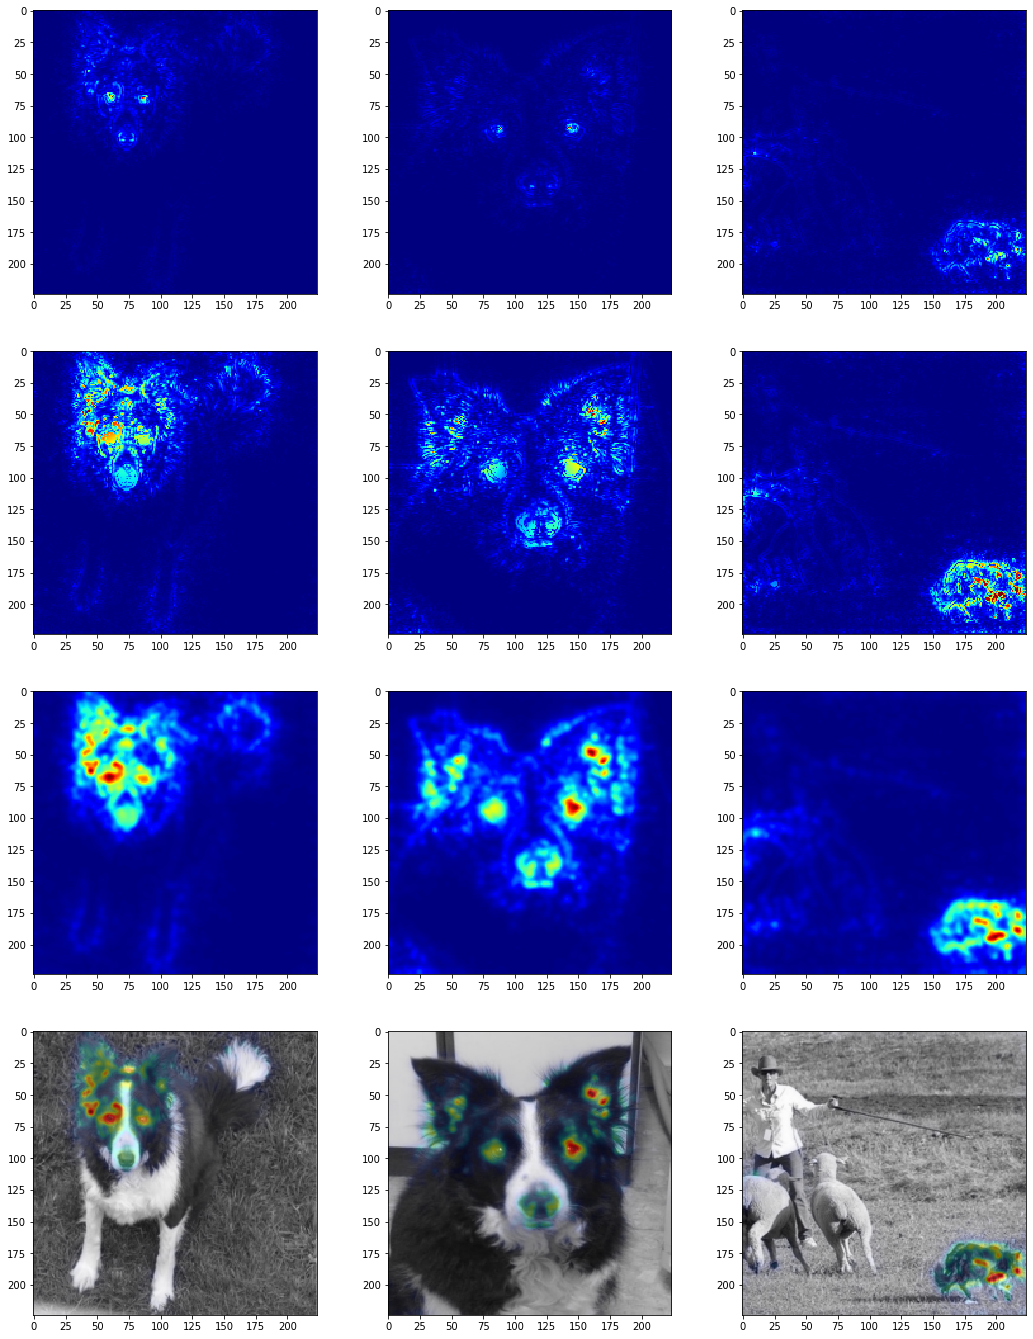

In [0]:
#note this is different from keras-vis grad-cam with modifier="guided"
viz(filter_indices=label2index['Border_collie'], method='both')